# 二手房交易分析

## 目标

通过数据分析，对后续二手房交易策略提供支持，计划进行如下维度分析

1. 小区户型交易热点，掌握哪些户型易于成交
2. 用户行为，户型与交易周期的关系，了解一个新挂的二手房，什么情况下可能成交，以及相应的议价空间
3. 交易趋势，确认政策对交易的量化影响，以及目前的价格走势

随后形成如下认知：

1. 户型后续出手难度
2. 户型定价策略，报价博弈策略
3. 潜在竞争客户应对策略

最终用户如下决策

1. 买什么户型
2. 报多少价格
3. 如何进行议价

# 结论模板

1. 交易热点：小区成交热点户型，面积，朝向，楼层
2. 交易趋势：成交均价随月份趋势和分布，挂牌价与成交价gap的均值和线框图
3. 交易行为：成交前平均带看次数和成交周期分布和趋势

# 通用结论

影响价格因素：户型，朝向，楼层

朝向好，价格高

楼层方面：无电梯小区，底层、低楼层，中楼层价格相近，高于高层和顶层

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

# 一. 数据载入&预处理

In [3]:
# 载入数据
#data = pd.read_csv('../教场口6号院.csv')
data = pd.read_csv('../东直门南大街.csv')

In [4]:
# 预览数据
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,listing_time,last_transaction_duration,transaction_price,history_trade_count,listed_price,transaction_duration,price_change_count,visit_count,follower_count,page_view_count
0,东直门南大街 1室1厅 42.02平米,2020.01.14,东直门南大街,1室1厅1厨1卫,高楼层(共18层),42.02㎡,板塔结合,东,1990,101106407400,2019-12-01,满五年,435,1,450,45,1,38,32,暂无数据
1,东直门南大街 3室1厅 93.66平米,2019.04.22,东直门南大街,3室1厅1厨1卫,中楼层(共18层),93.66㎡,板塔结合,南,1991,101104427611,2019-04-04,满五年,800,1,830,18,0,20,27,667
2,东直门南大街 3室1厅 93.66平米,2019.06.16,东直门南大街,3室1厅1厨1卫,中楼层(共18层),93.66㎡,板塔结合,南,1991,101104117761,2019-02-22,满五年,788,1,815,115,1,72,110,3508


In [5]:
# 预览大小和特征数
data.shape

(174, 20)

In [6]:
#处理日期数据
data['deal_date'] = pd.to_datetime(data['deal_date'])
data['listing_time'] = pd.to_datetime(data['listing_time'], errors='coerce')
data['deal_month'] = data['deal_date'].dt.to_period('M').dt.to_timestamp()
data['deal_year'] = data['deal_date'].dt.to_period('Y').dt.to_timestamp()

In [7]:
# 转成整数类型日期
data['deal_month_num'] = data['deal_month'].dt.strftime('%Y%m')
data['deal_month_num'] = data['deal_month_num'].map(lambda x:int(x) if isinstance(x, str) else x)

In [8]:
data.dtypes

title                                object
deal_date                    datetime64[ns]
community                            object
house_type                           object
floor                                object
area                                 object
building_type                        object
orientation                          object
build_year                            int64
lianjia_id                           object
listing_time                 datetime64[ns]
last_transaction_duration            object
transaction_price                    object
history_trade_count                   int64
listed_price                         object
transaction_duration                 object
price_change_count                    int64
visit_count                           int64
follower_count                        int64
page_view_count                      object
deal_month                   datetime64[ns]
deal_year                    datetime64[ns]
deal_month_num                  

In [9]:
# 处理数值型数据转换
# 成交周期
data['transaction_duration'] = data['transaction_duration'].map(lambda x: np.nan if x=='暂无数据' or x is np.nan else int(x)).astype('Int64',errors='ignore')
# 面积
data['area'] = data['area'].map(lambda x: float(x.strip('㎡') if x != '暂无数据' else np.nan))
# 判断是否是链家成交
def is_lianjia_deal(priceStr):
    if priceStr == '暂无数据':
        return False
    elif '-' not in priceStr:
        return True
    else:
        return False
data['is_lianjia_deal'] = data['transaction_price'].map(is_lianjia_deal)
# 成交价
def convert_int(numberStr):
    if isinstance(numberStr, int) or isinstance(numberStr, float):
        return numberStr
    if numberStr == '暂无数据':
        return np.nan
    elif '.' in numberStr:
        return int(numberStr.split('.')[0])
    elif '-' not in numberStr:
        return int(numberStr)
    else:
        low,up = numberStr.split('-')
        return int((int(low)+int(up))/2)
data['transaction_price'] = data['transaction_price'].map(convert_int)

# 挂牌价
data['listed_price'] = data['listed_price'].map(convert_int).astype('Int64')

# 浏览数
data['page_view_count'] = data['page_view_count'].map(convert_int).astype('Int64')

In [10]:
#处理字符串类型
# 朝向
data['orientation'] = data['orientation'].map(lambda x: ''.join(set([i for i in x if i != ' '])))

In [12]:
# 新列
# 每平米价格
data['per_area_price'] = data['transaction_price']/data['area']
# 成交价-报价
data['transaction_listed_price_gap'] = data['transaction_price']-data['listed_price']

def convert_area_level(area):
    return int(round(area/10))*10

def convert_room_count(house_type):
    try:
        return int(house_type[0])
    except Exception:
        return 0

# 面积阶梯
data['area_level'] = data['area'].map(convert_area_level)
# 房间数归一化
data['room_count'] = data['house_type'].map(convert_room_count)

In [13]:
data.dtypes

title                                   object
deal_date                       datetime64[ns]
community                               object
house_type                              object
floor                                   object
area                                   float64
building_type                           object
orientation                             object
build_year                               int64
lianjia_id                              object
listing_time                    datetime64[ns]
last_transaction_duration               object
transaction_price                        int64
history_trade_count                      int64
listed_price                             Int64
transaction_duration                     Int64
price_change_count                       int64
visit_count                              int64
follower_count                           int64
page_view_count                          Int64
deal_month                      datetime64[ns]
deal_year    

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 28 columns):
title                           174 non-null object
deal_date                       174 non-null datetime64[ns]
community                       174 non-null object
house_type                      174 non-null object
floor                           174 non-null object
area                            174 non-null float64
building_type                   174 non-null object
orientation                     174 non-null object
build_year                      174 non-null int64
lianjia_id                      174 non-null object
listing_time                    174 non-null datetime64[ns]
last_transaction_duration       174 non-null object
transaction_price               174 non-null int64
history_trade_count             174 non-null int64
listed_price                    167 non-null Int64
transaction_duration            103 non-null Int64
price_change_count              174 non-null int64


In [15]:
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,...,follower_count,page_view_count,deal_month,deal_year,deal_month_num,is_lianjia_deal,per_area_price,transaction_listed_price_gap,area_level,room_count
0,东直门南大街 1室1厅 42.02平米,2020-01-14,东直门南大街,1室1厅1厨1卫,高楼层(共18层),42.02,板塔结合,东,1990,101106407400,...,32,NaN,2020-01-01,2020-01-01,202001,True,10.352213,-15,40,1
1,东直门南大街 3室1厅 93.66平米,2019-04-22,东直门南大街,3室1厅1厨1卫,中楼层(共18层),93.66,板塔结合,南,1991,101104427611,...,27,667,2019-04-01,2019-01-01,201904,True,8.541533,-30,90,3
2,东直门南大街 3室1厅 93.66平米,2019-06-16,东直门南大街,3室1厅1厨1卫,中楼层(共18层),93.66,板塔结合,南,1991,101104117761,...,110,3508,2019-06-01,2019-01-01,201906,True,8.413410,-27,90,3


# 二. 数据分析

户型种类

In [16]:
print(data['house_type'].unique())

['1室1厅1厨1卫' '3室1厅1厨1卫' '2室1厅1厨1卫' '2室0厅1厨1卫' '- -室- -厅']


建成年代

In [17]:
print(data['build_year'].unique())

[1990 1991]


链家成交占比


In [18]:
data[data['is_lianjia_deal']==True]['title'].count()/data['title'].count()

0.8218390804597702

## 2.1 交易行为

### 1）户型交易分布

可以查看交易主力户型和朝向

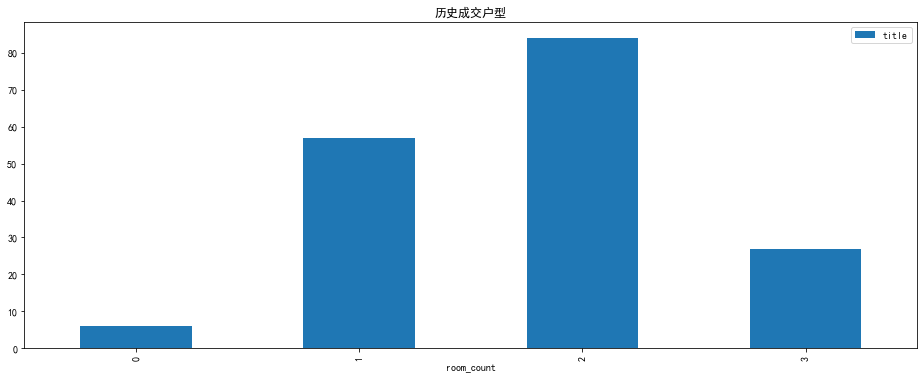

In [19]:
data.groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型')

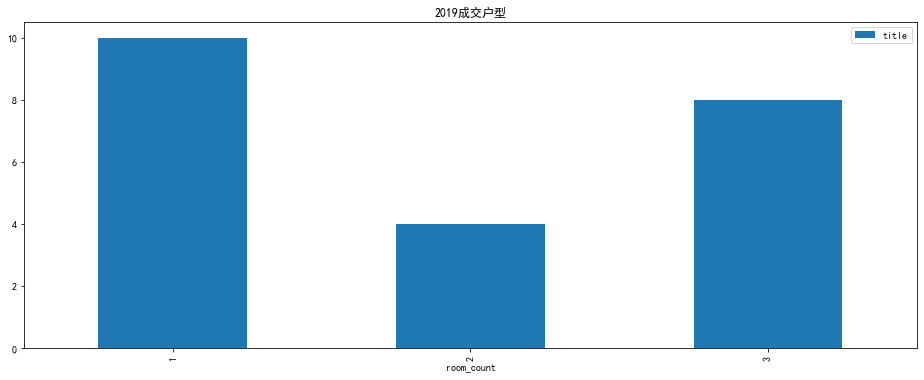

In [20]:
data[data['deal_date']>='2019'].groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交户型')

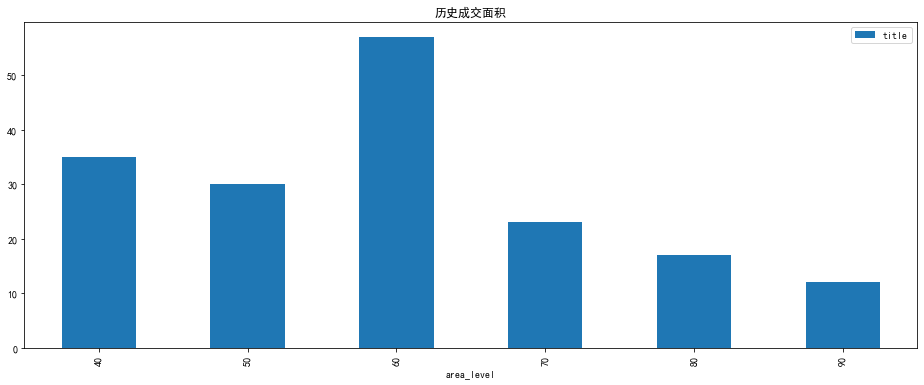

In [21]:
data.groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交面积')

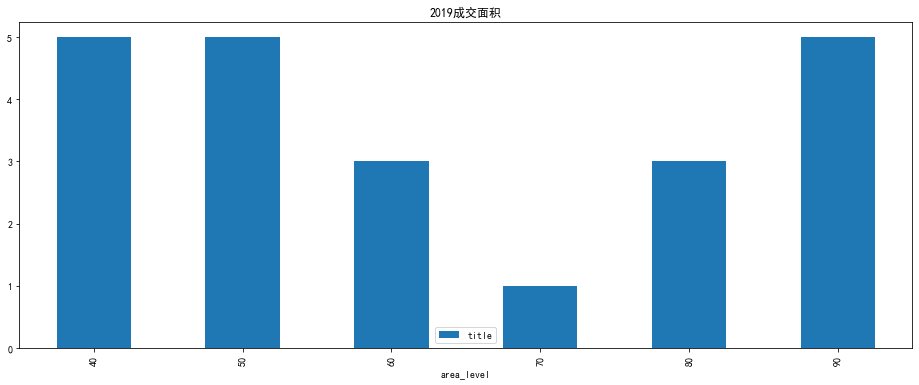

In [22]:
data[data['deal_date']>='2019'].groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交面积')

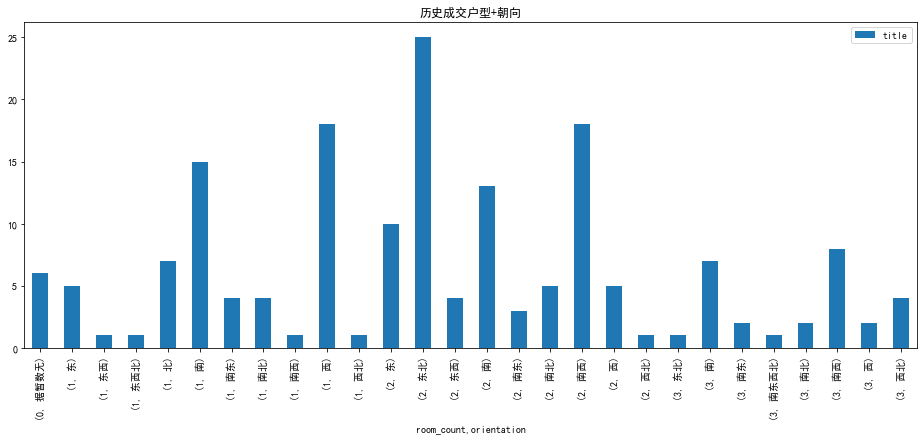

In [23]:
data.groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型+朝向')

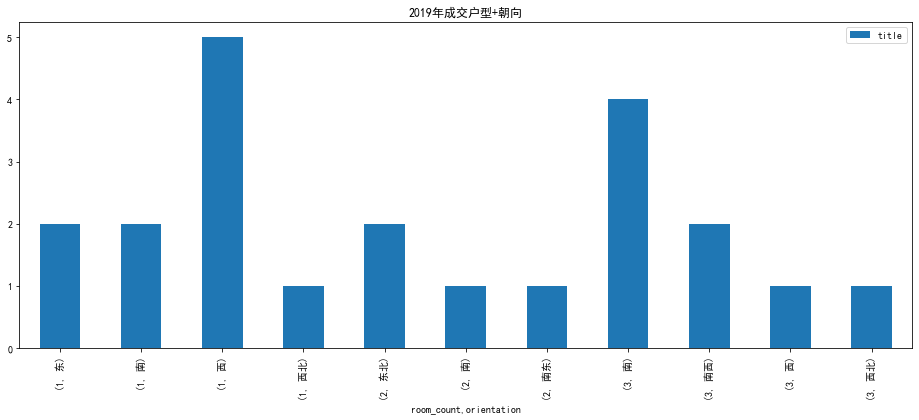

In [24]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交户型+朝向')

分户型朝向和楼层的成交分布

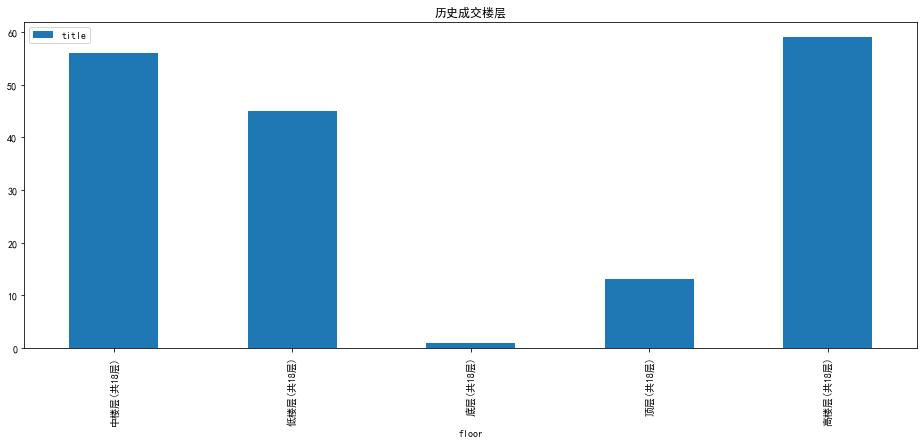

In [25]:
data.groupby(['floor']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交楼层')

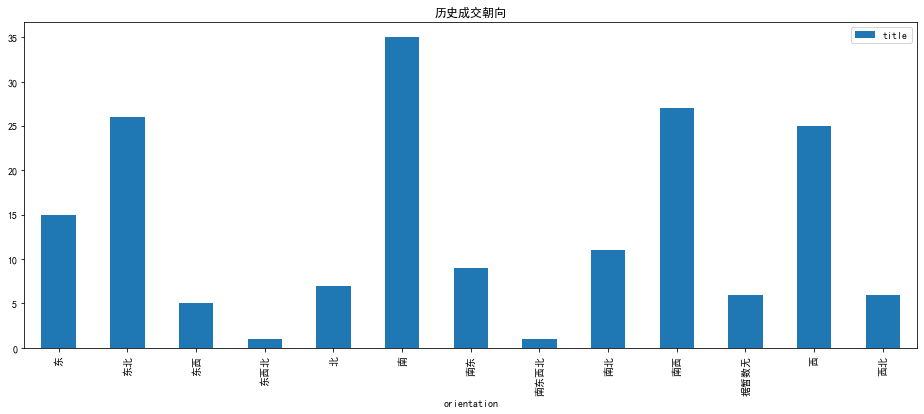

In [26]:
data.groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交朝向')

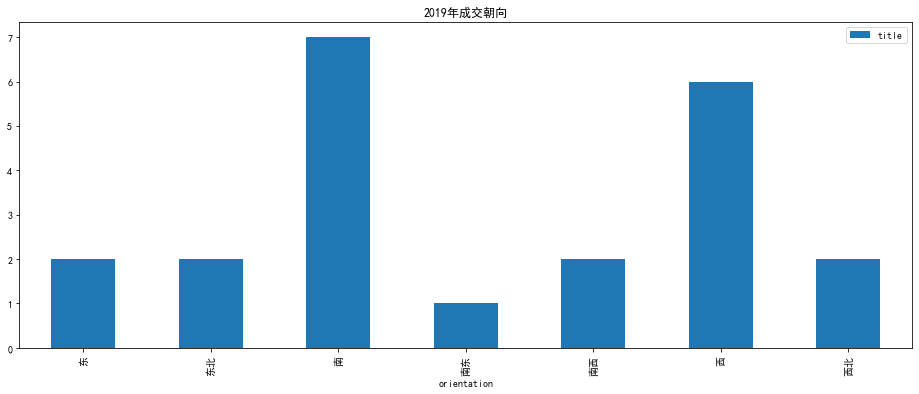

In [27]:
data[data['deal_date']>='2019'].groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交朝向')

In [28]:
data.groupby(['house_type','orientation','floor']).count()[['title']]

title
house_type orientation floor           
- -室- -厅   据暂数无        中楼层(共18层)      3
                       低楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      1
1室1厅1厨1卫   东           中楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      3
           东西          低楼层(共18层)      1
           东西北         低楼层(共18层)      1
           北           中楼层(共18层)      1
                       低楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      4
           南           中楼层(共18层)      3
                       低楼层(共18层)      5
                       顶层(共18层)       1
                       高楼层(共18层)      6
           南东          中楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      2
           南北          中楼层(共18层)      2
                       高楼层(共18层)      2
           南西          底层(共18层)       1
           西           中楼层(共18层)      3
                       低楼层(共18层)      7
                       顶层(共18层)       1
                       高楼层(共18层)      7
           西北          高楼层(共18层)      1
2室0厅1厨1卫   东           中楼层(共18层)      1
                       低楼层(共18层)      1
           西           中楼层(共18层)      1
2室1厅1厨1卫   东           中楼层(共18层)      4
                       低楼层(共18层)      2
                       高楼层(共18层)      2
           东北          中楼层(共18层)      8
                       低楼层(共18层)      9
                       高楼层(共18层)      8
           东西          中楼层(共18层)      3
                       高楼层(共18层)      1
           南           中楼层(共18层)      4
                       低楼层(共18层)      2
                       顶层(共18层)       2
                       高楼层(共18层)      5
           南东          中楼层(共18层)      1
                       低楼层(共18层)      1
                       高楼层(共18层)      1
           南北          中楼层(共18层)      1
                       低楼层(共18层)      2
                       高楼层(共18层)      2
           南西          中楼层(共18层)      9
                       低楼层(共18层)      3
                       顶层(共18层)       2
                       高楼层(共18层)      4
           西           中楼层(共18层)      1
                       低楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      1
           西北          中楼层(共18层)      1
3室1厅1厨1卫   东北          高楼层(共18层)      1
           南           中楼层(共18层)      2
                       低楼层(共18层)      3
                       顶层(共18层)       1
                       高楼层(共18层)      1
           南东          中楼层(共18层)      1
                       低楼层(共18层)      1
           南东西北        中楼层(共18层)      1
           南北          高楼层(共18层)      2
           南西          中楼层(共18层)      3
                       低楼层(共18层)      3
                       高楼层(共18层)      2
           西           高楼层(共18层)      2
           西北          中楼层(共18层)      1
                       低楼层(共18层)      1
                       顶层(共18层)       1
                       高楼层(共18层)      1

In [29]:
data.groupby(['area','orientation','floor']).count()[['title']]

title
area  orientation floor           
39.93 南           中楼层(共18层)      3
                  低楼层(共18层)      2
                  顶层(共18层)       1
                  高楼层(共18层)      1
      南北          高楼层(共18层)      1
      西           中楼层(共18层)      1
                  低楼层(共18层)      2
                  高楼层(共18层)      3
40.63 西           中楼层(共18层)      1
                  低楼层(共18层)      2
                  高楼层(共18层)      1
40.72 西           顶层(共18层)       1
41.80 北           顶层(共18层)       1
                  高楼层(共18层)      1
41.83 北           高楼层(共18层)      2
41.87 北           高楼层(共18层)      1
42.02 东           顶层(共18层)       1
                  高楼层(共18层)      2
43.46 东           中楼层(共18层)      2
44.36 南           低楼层(共18层)      2
      南东          中楼层(共18层)      1
                  顶层(共18层)       1
                  高楼层(共18层)      2
45.79 东           高楼层(共18层)      1
      南           高楼层(共18层)      1
      南北          中楼层(共18层)      1
46.00 南           低楼层(共18层)      1
46.26 北           中楼层(共18层)      1
                  低楼层(共18层)      1
46.36 东西          低楼层(共18层)      1
      西           低楼层(共18层)      3
                  高楼层(共18层)      3
46.53 南           高楼层(共18层)      1
47.00 南           高楼层(共18层)      1
47.17 南西          底层(共18层)       1
47.18 南           高楼层(共18层)      2
      南北          中楼层(共18层)      1
                  高楼层(共18层)      1
      据暂数无        中楼层(共18层)      1
47.27 西北          高楼层(共18层)      1
47.92 东           低楼层(共18层)      2
48.02 东西北         低楼层(共18层)      1
      西           中楼层(共18层)      1
48.97 东           高楼层(共18层)      1
      东北          中楼层(共18层)      1
49.00 东           中楼层(共18层)      1
53.53 东北          低楼层(共18层)      1
55.29 东北          低楼层(共18层)      1
      南西          低楼层(共18层)      1
56.40 南           高楼层(共18层)      1
      南东          低楼层(共18层)      1
      南西          中楼层(共18层)      2
                  低楼层(共18层)      1
                  顶层(共18层)       1
                  高楼层(共18层)      2
      西           中楼层(共18层)      1
56.96 东           低楼层(共18层)      1
57.14 东           中楼层(共18层)      1
57.67 东北          高楼层(共18层)      1
57.98 东           中楼层(共18层)      1
      东北          中楼层(共18层)      4
                  低楼层(共18层)      2
                  高楼层(共18层)      3
57.99 东北          低楼层(共18层)      1
                  高楼层(共18层)      2
58.00 东北          高楼层(共18层)      1
58.77 南西          中楼层(共18层)      3
                  顶层(共18层)       1
61.42 东北          低楼层(共18层)      1
61.59 东           中楼层(共18层)      1
      东北          中楼层(共18层)      2
                  低楼层(共18层)      2
                  高楼层(共18层)      1
61.60 东北          低楼层(共18层)      1
62.72 南           中楼层(共18层)      2
                  低楼层(共18层)      1
                  顶层(共18层)       1
                  高楼层(共18层)      1
      西           顶层(共18层)       1
63.29 南           中楼层(共18层)      1
      南西          中楼层(共18层)      1
                  高楼层(共18层)      1
63.40 南           低楼层(共18层)      1
63.56 据暂数无        高楼层(共18层)      1
63.60 南西          高楼层(共18层)      1
64.02 南           顶层(共18层)       1
                  高楼层(共18层)      1
      南西          中楼层(共18层)      3
65.11 东           高楼层(共18层)      1
      东西          中楼层(共18层)      1
                  高楼层(共18层)      1
      南           中楼层(共18层)      1
                  高楼层(共18层)      1
      南北          中楼层(共18层)      1
                  高楼层(共18层)      1
65.30 南东          中楼层(共18层)      1
65.33 南东          高楼层(共18层)      1
      西           高楼层(共18层)      1
      西北          中楼层(共18层)      1
67.81 东西          中楼层(共18层)      2
67.84 南北          低楼层(共18层)      1
68.17 南北          低楼层(共18层)      1
68.51 东北          中楼层(共18层)      1
      南西          低楼层(共18层)      1
69.55 西           中楼层(共18层)      1
69.64 南           高楼层(共18层)      1
      南北          高楼层(共18层)      1
73.01 东北          高楼层(共18层)      1
      南西          低楼层(共18层)      1
      据暂数无        低楼层(共18层)      1
75.96 南           低楼层(共18层)      1
77.02 南东西北        中楼层(共18层)      1
      南北          高楼层(共18层)      1
80.1

In [30]:
data.groupby(['area']).count()[['title']]

,title
area,
39.93,14
40.63,4
40.72,1
41.80,2
41.83,2
41.87,1
42.02,3
43.46,2
44.36,6


### 2）换手率

分户型分析换手情况

成交超过1次，分户型交易占比

In [31]:
data.groupby(['room_count', 'history_trade_count']).count()[['title']]

title
room_count history_trade_count       
0          1                        5
           2                        1
1          1                       47
           2                       10
2          1                       74
           2                       10
3          1                       24
           2                        3

In [32]:
(data[data['history_trade_count']>1].groupby('room_count').count()/2/data.groupby('room_count').count())[['title']]

,title
room_count,
0,0.083333
1,0.087719
2,0.059524
3,0.055556


### 3）带看与成交周期

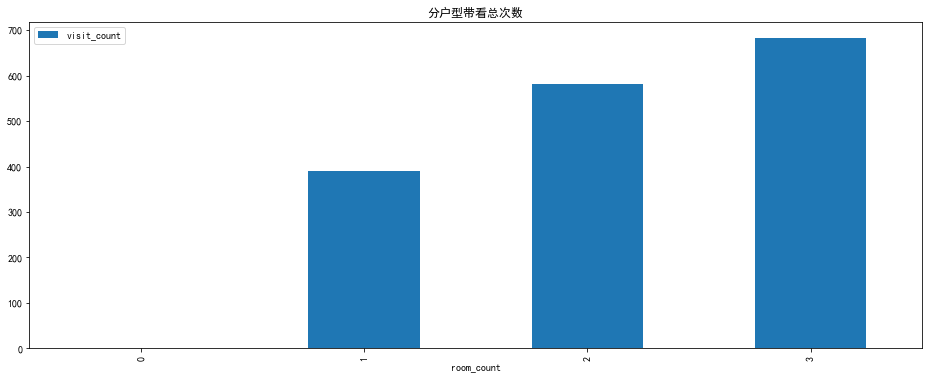

In [33]:
data.groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型带看总次数')

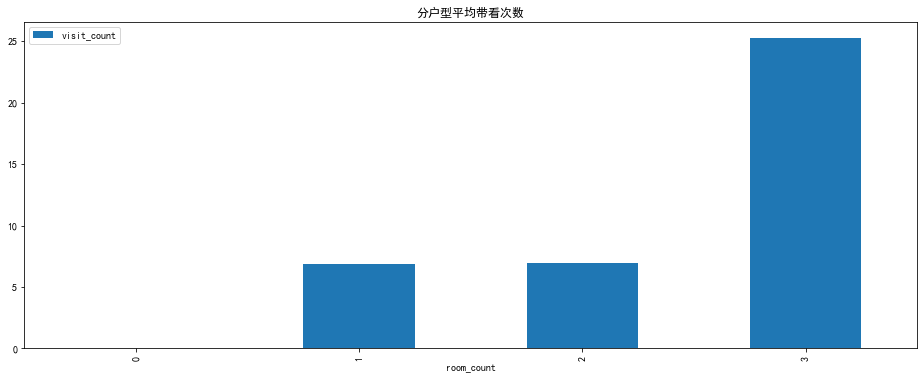

In [34]:
data.groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型平均带看次数')

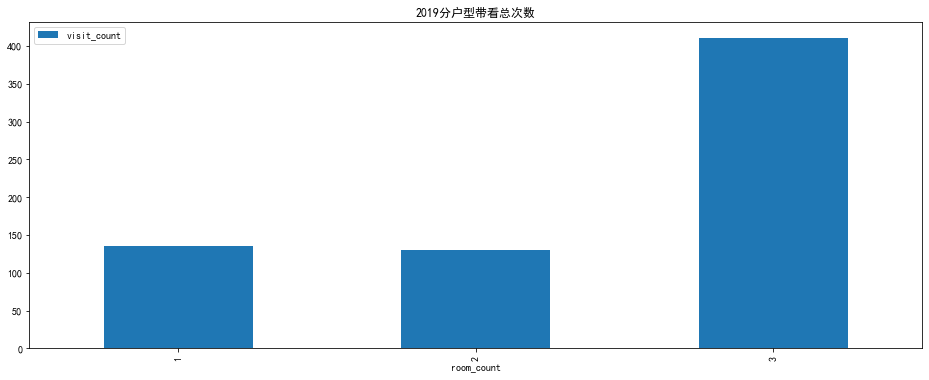

In [35]:
data[data['deal_date']>='2019'].groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型带看总次数')

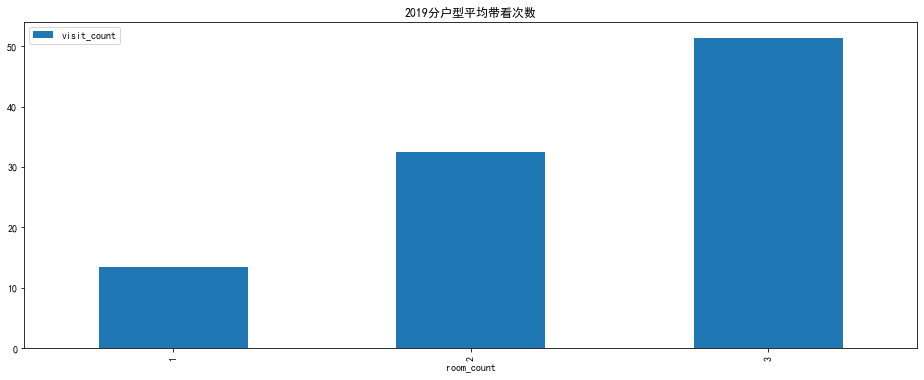

In [36]:
data[data['deal_date']>='2019'].groupby(['room_count']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型平均带看次数')

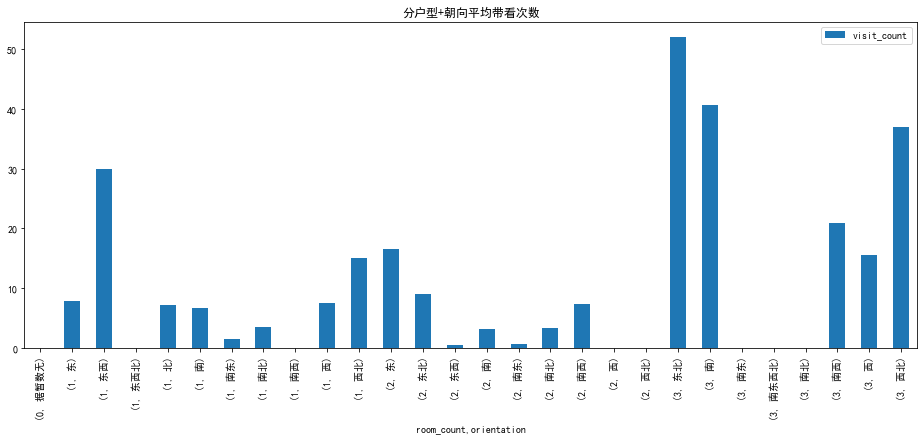

In [37]:
data.groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型+朝向平均带看次数')

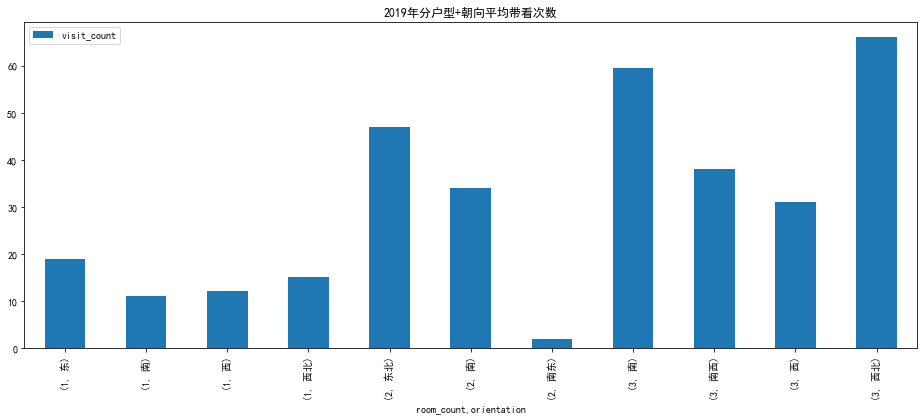

In [38]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019年分户型+朝向平均带看次数')

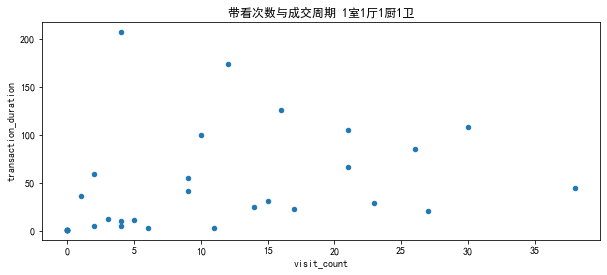

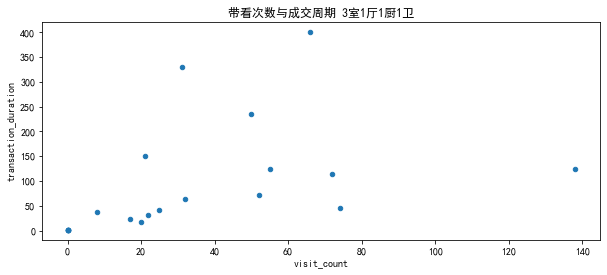

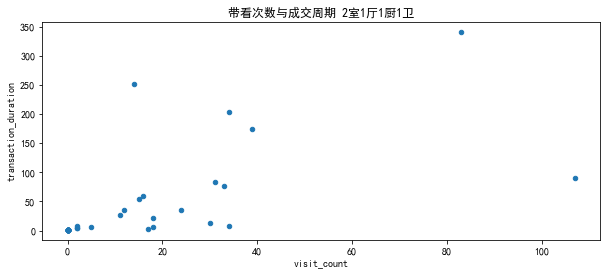

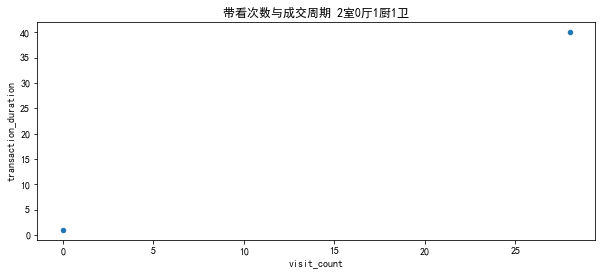

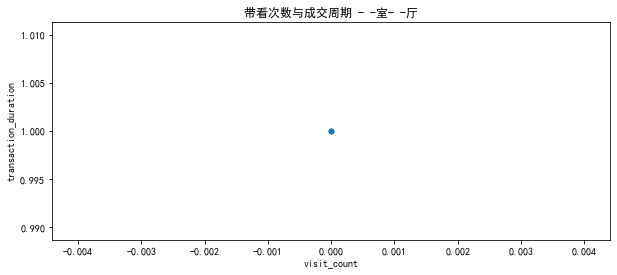

In [39]:
for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_duration','visit_count']].plot(kind='scatter',x='visit_count', y='transaction_duration',figsize=(10,4),title='带看次数与成交周期 '+t)

分户型成交周期分布

In [40]:
data.groupby(['room_count','orientation','floor']).describe()[['transaction_duration']]

transaction_duration                          \
                                                count        mean         std   
room_count orientation floor                                                    
0          据暂数无        中楼层(共18层)                  3.0    1.000000    0.000000   
                       低楼层(共18层)                  1.0    1.000000         NaN   
                       顶层(共18层)                   1.0    1.000000         NaN   
                       高楼层(共18层)                  1.0    1.000000         NaN   
1          东           中楼层(共18层)                  0.0         NaN         NaN   
                       顶层(共18层)                   0.0         NaN         NaN   
                       高楼层(共18层)                  3.0   27.333333   23.245071   
           东西          低楼层(共18层)                  1.0  108.000000         NaN   
           东西北         低楼层(共18层)                  0.0         NaN         NaN   
           北           中楼层(共18层)                  0.0         NaN         NaN   
                       低楼层(共18层)                  0.0         NaN         NaN   
                       顶层(共18层)                   0.0         NaN         NaN   
                       高楼层(共18层)                  2.0    1.000000    0.000000   
           南           中楼层(共18层)                  1.0  174.000000         NaN   
                       低楼层(共18层)                  2.0  118.000000  125.865007   
                       顶层(共18层)                   0.0         NaN         NaN   
                       高楼层(共18层)                  5.0   73.400000   47.930158   
           南东          中楼层(共18层)                  1.0    5.000000         NaN   
                       顶层(共18层)                   1.0    5.000000         NaN   
                       高楼层(共18层)                  0.0         NaN         NaN   
           南北          中楼层(共18层)                  1.0   25.000000         NaN   
                       高楼层(共18层)                  0.0         NaN         NaN   
           南西          底层(共18层)                   0.0         NaN         NaN   
           西           中楼层(共18层)                  3.0   35.666667   60.044428   
                       低楼层(共18层)                  3.0   33.666667   29.143324   
                       顶层(共18层)                   1.0    1.000000         NaN   
                       高楼层(共18层)                  7.0   21.571429   21.430952   
           西北          高楼层(共18层)                  1.0   31.000000         NaN   
2          东           中楼层(共18层)                  3.0   18.000000   19.974984   
                       低楼层(共18层)                  0.0         NaN         NaN   
                       高楼层(共18层)                  2.0   45.500000   62.932504   
           东北          中楼层(共18层)                  5.0   81.600000  146.582059   
                       低楼层(共18层)                  6.0   14.333333   21.068143   
                       高楼层(共18层)                  7.0   10.428571   14.187520   
           东西          中楼层(共18层)                  2.0    4.500000    4.949747   
                       高楼层(共18层)                  0.0         NaN         NaN   
           南           中楼层(共18层)                  1.0    1.000000         NaN   
                       低楼层(共18层)                  1.0    1.000000         NaN   
                       顶层(共18层)                   1.0    1.000000         NaN   
                       高楼层(共18层)                  2.0  102.500000  143.542677   
           南东          中楼层(共18层)                  1.0    1.000000         NaN   
                       低楼层(共18层)                  1.0    1.000000         NaN   
                       高楼层(共18层)                  1.0    4.000000         NaN   
           南北          中楼层(共18层)                  0.0         NaN         NaN   
                       低楼层(共18层)                  0.0         NaN         NaN   
                       高楼层(共18层)                  1.0    2.000000         NaN   
           南西          中楼层(共18层)                  6.0   21.00000

tuple index out of range 2室0厅1厨1卫
tuple index out of range - -室- -厅


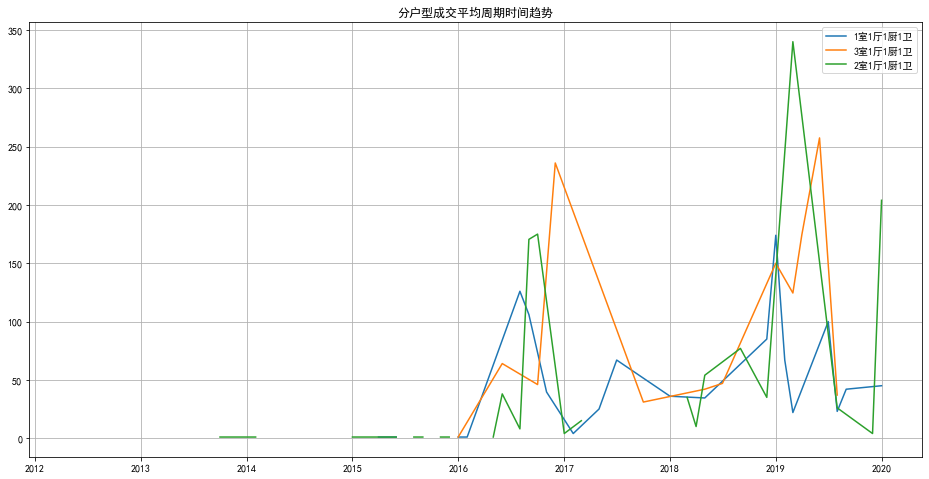

In [41]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    try:
        plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_duration'])
    except Exception as e:
        print(e,t)
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交平均周期时间趋势')
plt.show()

### 4) 成交量时间趋势

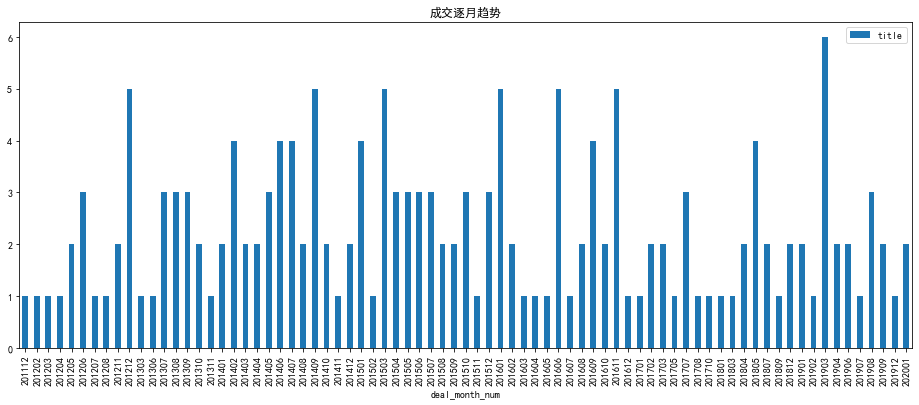

In [42]:
data.groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='成交逐月趋势')
#ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))

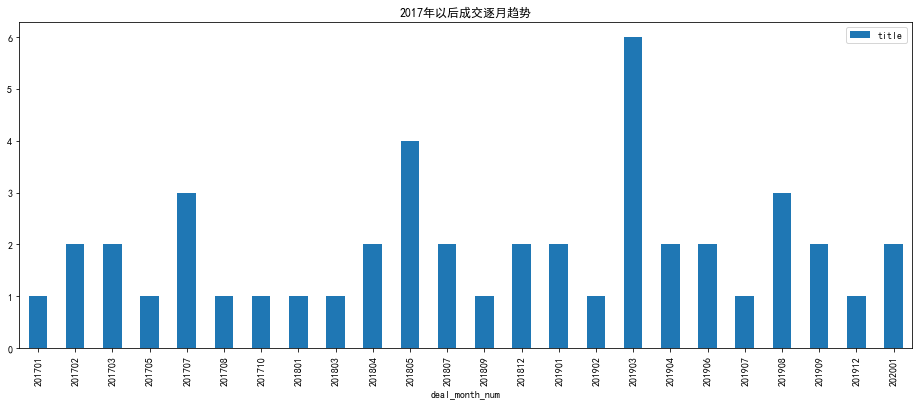

In [43]:
data[data['deal_date']>='2017'].groupby('deal_month_num').count()[['title']].plot(kind='bar', figsize=(16,6), title='2017年以后成交逐月趋势')

## 2.2 价格机制

相同面积，房间数下，影响价格的因素主要是朝向和楼层

### 1）分户型平均成交价格走势

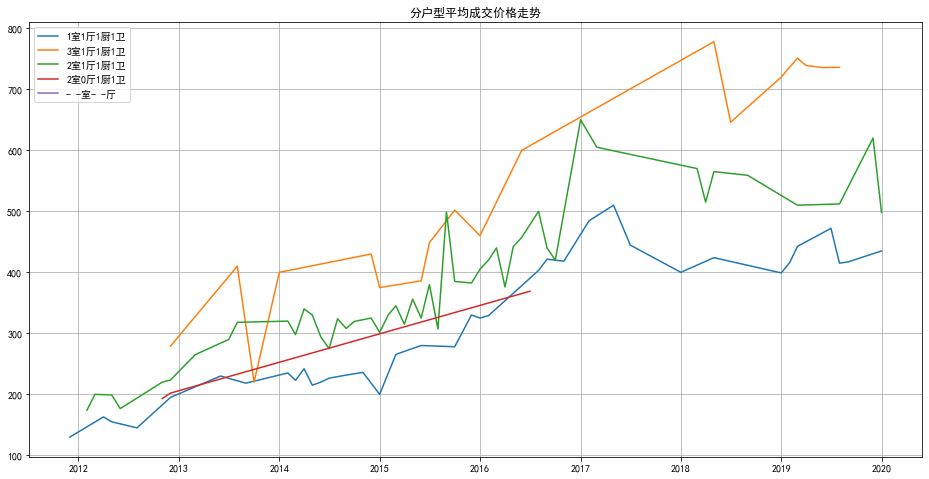

In [64]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[(data['house_type']==t) & (data['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型平均成交价格走势')
plt.show()

### 2）2019年分户型不同楼层成交均价

In [45]:
data[(data['deal_date']>'2019') & (data['is_lianjia_deal']==True) ].groupby(['house_type','area','floor', 'build_year'])[['transaction_price','per_area_price']].mean()

transaction_price  per_area_price
house_type area  floor     build_year                                   
1室1厅1厨1卫   39.93 中楼层(共18层) 1991                    399.0        9.992487
                 低楼层(共18层) 1991                    415.0       10.393188
                 高楼层(共18层) 1991                    416.0       10.418232
           42.02 高楼层(共18层) 1990                    435.0       10.352213
           46.36 低楼层(共18层) 1991                    416.0        8.973253
           47.18 高楼层(共18层) 1990                    472.0       10.004239
           47.27 高楼层(共18层) 1990                    470.0        9.942881
2室1厅1厨1卫   56.40 高楼层(共18层) 1991                    498.0        8.829787
           57.67 高楼层(共18层) 1991                    512.0        8.878100
           57.98 中楼层(共18层) 1991                    510.0        8.796137
           65.33 高楼层(共18层) 1991                    620.0        9.490280
3室1厅1厨1卫   80.17 高楼层(共18层) 1991                    680.5        8.488213
           84.28 低楼层(共18层) 1991                    720.0        8.542952
           87.67 低楼层(共18层) 1991                    754.0        8.600433
           87.74 高楼层(共18层) 1990                    748.0        8.525188
           89.39 顶层(共18层)  1990                    736.0        8.233583
           93.66 中楼层(共18层) 1991                    794.0        8.477472

### 3）各个户型最后成交价格

户型锚定价格

In [46]:
data.sort_values('deal_date').groupby(['house_type','area','floor'])[['transaction_price','deal_date','is_lianjia_deal','lianjia_id']].last()

transaction_price  deal_date  is_lianjia_deal  \
house_type area  floor                                                      
- -室- -厅   47.18 中楼层(共18层)                340 2016-01-01            False   
           63.56 高楼层(共18层)                341 2014-02-01            False   
           73.01 低楼层(共18层)                380 2014-09-01            False   
           86.98 中楼层(共18层)                410 2013-08-01            False   
           89.37 中楼层(共18层)                390 2013-11-01            False   
                 顶层(共18层)                 397 2014-01-01            False   
1室1厅1厨1卫   39.93 中楼层(共18层)                399 2019-01-24             True   
                 低楼层(共18层)                415 2019-03-08             True   
                 顶层(共18层)                 200 2013-09-01             True   
                 高楼层(共18层)                417 2019-09-05             True   
           40.63 中楼层(共18层)                280 2015-06-28             True   
                 低楼层(共18层)                416 2016-11-15             True   
                 高楼层(共18层)                420 2016-11-19             True   
           40.72 顶层(共18层)                 200 2015-01-25             True   
           41.80 顶层(共18层)                 278 2015-10-16             True   
                 高楼层(共18层)                220 2014-06-28             True   
           41.83 高楼层(共18层)                378 2017-07-01            False   
           41.87 高楼层(共18层)                260 2015-04-01            False   
           42.02 顶层(共18层)                 210 2013-09-14             True   
                 高楼层(共18层)                435 2020-01-14             True   
           44.36 中楼层(共18层)                445 2016-09-26             True   
                 低楼层(共18层)                243 2014-09-08             True   
                 顶层(共18层)                 483 2017-02-12             True   
                 高楼层(共18层)                330 2015-12-21             True   
           45.79 中楼层(共18层)                267 2015-03-21             True   
                 高楼层(共18层)                460 2016-11-24             True   
           46.00 低楼层(共18层)                439 2017-07-28             True   
           46.26 中楼层(共18层)                242 2014-04-27             True   
                 低楼层(共18层)                233 2014-07-09             True   
           46.36 低楼层(共18层)                435 2019-03-01            False   
                 高楼层(共18层)                418 2018-05-18             True   
           46.53 高楼层(共18层)                240 2014-05-01            False   
           47.00 高楼层(共18层)                403 2016-08-20             True   
           47.17 底层(共18层)                 230 2013-06-23             True   
           47.18 中楼层(共18层)                510 2017-05-25             True   
                 高楼层(共18层)                472 2019-07-19             True   
           47.27 高楼层(共18层)                470 2019-03-31             True   
           48.02 中楼层(共18层)                450 2017-07-07             True   
                 低楼层(共18层)                264 2015-03-02             True   
           49.00 中楼层(共18层)                456 2019-09-01            False   
2室0厅1厨1卫   43.46 中楼层(共18层)                369 2016-07-24             True   
           47.92 低楼层(共18层)                202 2012-12-30             True   
           56.40 中楼层(共18层)                193 2012-11-20             True   
2室1厅1厨1卫   43.46 中楼层(共18层)                376 2016-04-03             True   
           47.92 低楼层(共18层)                160 2012-06-02             True   
           48.97 中楼层(共18层)                398 2016-06-22             True   
                 高楼层(共18层)                430 2016-09-08             True   
           53.53 低楼层(共18层)                307 2015-08-22             True   
           55.29 低楼层(共18层)                420 2016-10-16             True   
           56.40 中楼层(共18层)                380 2015-11-01            False   
                 低楼层(共18

### 4）分户型楼层以及时间，挂牌价与成交价gap分布

In [47]:
#data.groupby(['house_type','area','floor','deal_year'])[['transaction_listed_price_gap']].describe()
data[data['is_lianjia_deal']==True].groupby(['house_type','deal_year'])[['transaction_listed_price_gap']].describe()

transaction_listed_price_gap                        \
                                             count       mean        std   
house_type deal_year                                                       
1室1厅1厨1卫   2011-01-01                          1.0   0.000000        NaN   
           2012-01-01                          4.0  -2.500000   2.081666   
           2013-01-01                          4.0  -1.250000   2.500000   
           2014-01-01                         10.0  -2.700000   7.165504   
           2015-01-01                          6.0  -5.500000   9.203260   
           2016-01-01                         10.0  -4.000000   3.399346   
           2017-01-01                          5.0 -27.200000  27.417148   
           2018-01-01                          3.0 -24.333333   9.291573   
           2019-01-01                          7.0 -12.142857   8.591247   
           2020-01-01                          1.0 -15.000000        NaN   
2室0厅1厨1卫   2012-01-01                          2.0 -12.500000  21.920310   
           2016-01-01                          1.0  -6.000000        NaN   
2室1厅1厨1卫   2012-01-01                         10.0  -6.500000   4.453463   
           2013-01-01                          4.0  -8.000000   5.354126   
           2014-01-01                         15.0  -9.533333   9.538394   
           2015-01-01                         15.0  -6.533333   6.577740   
           2016-01-01                         12.0  -9.250000  13.053213   
           2017-01-01                          3.0  -3.333333   2.886751   
           2018-01-01                          4.0 -16.500000  12.609520   
           2019-01-01                          3.0 -27.000000  10.148892   
           2020-01-01                          1.0 -28.000000        NaN   
3室1厅1厨1卫   2012-01-01                          1.0  -1.000000        NaN   
           2013-01-01                          2.0 -70.000000  84.852814   
           2014-01-01                          2.0 -12.500000  10.606602   
           2015-01-01                          5.0  -7.400000   4.979960   
           2016-01-01                          2.0  -9.000000  12.727922   
           2018-01-01                          2.0 -22.000000   2.828427   
           2019-01-01                          8.0 -22.250000  13.925824   

                                                         
                         min     25%   50%    75%   max  
house_type deal_year                                     
1室1厅1厨1卫   2011-01-01    0.0    0.00   0.0   0.00   0.0  
           2012-01-01   -5.0   -3.50  -2.5  -1.50   0.0  
           2013-01-01   -5.0   -1.25   0.0   0.00   0.0  
           2014-01-01  -10.0   -6.00  -5.0  -2.00  16.0  
           2015-01-01  -24.0   -3.75  -2.5  -0.50   0.0  
           2016-01-01  -10.0   -6.50  -3.0  -1.25   0.0  
           2017-01-01  -58.0  -56.00 -11.0  -9.00  -2.0  
           2018-01-01  -35.0  -27.50 -20.0 -19.00 -18.0  
           2019-01-01  -26.0  -17.00 -10.0  -7.50   0.0  
           2020-01-01  -15.0  -15.00 -15.0 -15.00 -15.0  
2室0厅1厨1卫   2012-01-01  -28.0  -20.25 -12.5  -4.75   3.0  
           2016-01-01   -6.0   -6.00  -6.0  -6.00  -6.0  
2室1厅1厨1卫   2012-01-01  -13.0  -10.00  -5.5  -5.00   0.0  
           2013-01-01  -15.0   -9.75  -7.5  -5.75  -2.0  
           2014-01-01  -30.0  -12.00  -6.0  -3.50   0.0  
           2015-01-01  -18.0  -10.00  -5.0  -3.50   8.0  
           2016-01-01  -48.0  -10.00  -8.5  -1.50   0.0  
           2017-01-01   -5.0   -5.00  -5.0  -2.50   0.0  
           2018-01-01  -30.0  -23.25 -18.0 -11.25   0.0  
           2019-01-01  -38.0  -31.50 -25.0 -21.50 -18.0  
           2020-01-01  -28.0  -28.00 -28.0 -28.00 -28.0  
3室1厅1厨1卫   2012-01-01   -1.0   -1.00  -1.0  -1.00  -1.0  
           2013-01-01 -130.0 -100.00 -70.0 -40.00 -10.0  
           2014-01-01  -20.0  -16.25 -12.5  -8.75  -5.0  
           2015-01-01  -15.0   -8.00  -8.0  -4.00  -2.0  
           2016-01-01  -18.0  -13.50  -9.

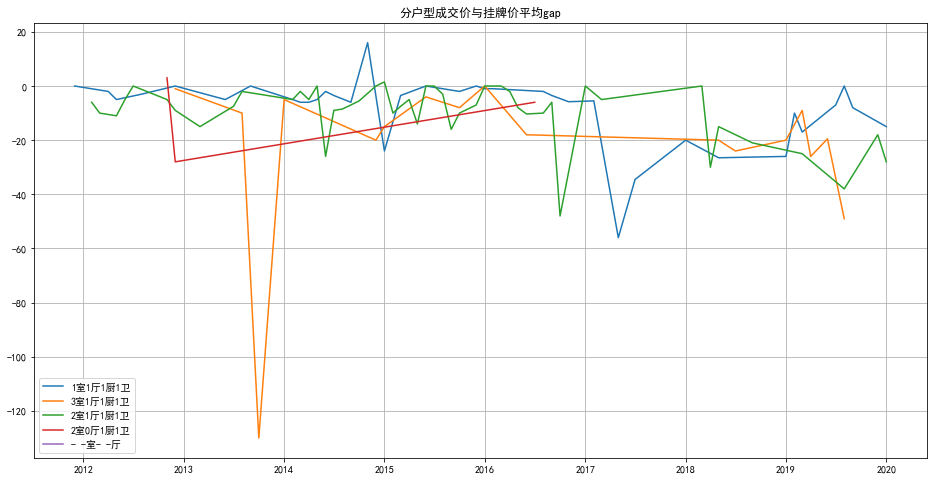

In [48]:
#plt.figure(figsize=(16, 8))
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[(data['house_type']==t) & (data['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.title('分户型成交价与挂牌价平均gap')
plt.show()

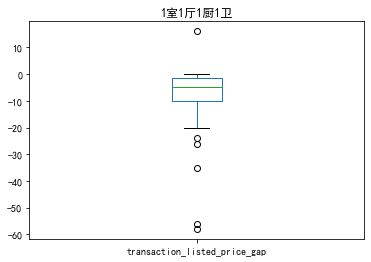

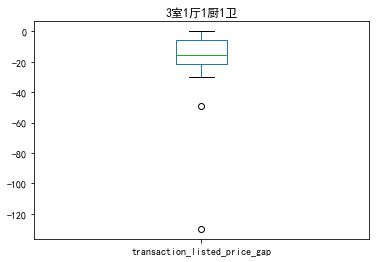

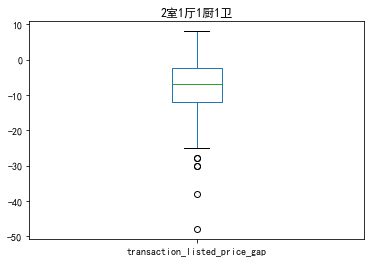

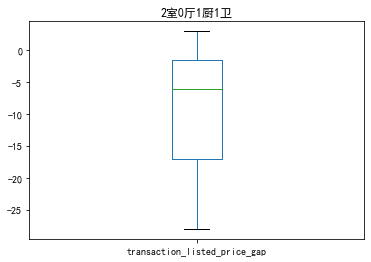

In [49]:

for t in data['house_type'].unique():
    try:
        data[(data['house_type']==t) & (data['is_lianjia_deal'] == True)][['transaction_listed_price_gap']].plot(kind='box', title=t)
    except:
        continue


In [50]:
#pd.plotting.scatter_matrix(data['transaction_duration','visit_count'], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#import matplotlib.pyplot as plt
#transaction_duration=data['transaction_duration']
#plt.figure(figsize=(20, 5))
#for i, col in enumerate(['visit_count']):
#    plt.subplot(1, 3, i+1)
#    plt.plot(data[col], transaction_duration, 'o')
#    plt.title(col)
#    plt.xlabel(col)
#plt.ylabel('transaction_duration')

### 5) 候选目标户型价格分析

In [65]:
#candidate = data[(abs((data['area']-55))<=1) & (data['deal_year']>='2017')]
#candidate = data[(data['area_level']==50) & (data['deal_year']>='2017')]
candidate = data[(data['room_count']==2) & (data['deal_year']>='2017')]

In [66]:
candidate.groupby('floor').count()[['title']]

,title
floor,
中楼层(共18层),4
低楼层(共18层),4
高楼层(共18层),6


In [67]:
candidate.groupby('last_transaction_duration').count()[['title']]

,title
last_transaction_duration,
暂无数据,7
满两年,2
满五年,5


In [74]:
candidate[['title','deal_month', 'floor', 'orientation', 'transaction_price', 'per_area_price', 'last_transaction_duration','lianjia_id','is_lianjia_deal']].sort_values('deal_month').head(100)

,title,deal_month,floor,orientation,transaction_price,per_area_price,last_transaction_duration,lianjia_id,is_lianjia_deal
56,东直门南大街 2室1厅 64.02平米,2017-01-01,中楼层(共18层),南西,650,10.153077,暂无数据,101101091030,True
32,东直门南大街 2室1厅 57.99平米,2017-03-01,低楼层(共18层),东北,595,10.260390,满五年,101101139793,True
33,东直门南大街 2室1厅 57.99平米,2017-03-01,高楼层(共18层),东北,615,10.605277,满五年,101101280218,True
38,东直门南大街 2室1厅 63.4平米,2017-08-01,低楼层(共18层),南,585,9.227129,暂无数据,101101909548,False
41,东直门南大街 2室1厅 64.02平米,2018-03-01,中楼层(共18层),南西,570,8.903468,暂无数据,101102570056,True
42,东直门南大街 2室1厅 61.6平米,2018-04-01,低楼层(共18层),东北,505,8.198052,暂无数据,101102700194,False
43,东直门南大街 2室1厅 57.14平米,2018-04-01,中楼层(共18层),东,515,9.012951,满两年,101102677576,True
16,东直门南大街 2室1厅 61.59平米,2018-05-01,低楼层(共18层),东北,565,9.173567,暂无数据,101102676665,True
12,东直门南大街 2室1厅 63.29平米,2018-09-01,高楼层(共18层),南西,559,8.832359,暂无数据,101103072253,True
14,东直门南大街 2室1厅 57.99平米,2018-12-01,高楼层(共18层),东北,508,8.760131,满五年,101103604019,False


In [69]:
# 目标楼层
candidate[candidate['floor']=='底层(共6层)'][['title','deal_month', 'floor', 'transaction_price', 'last_transaction_duration','lianjia_id','is_lianjia_deal']].sort_values('deal_month').head(100)

,title,deal_month,floor,transaction_price,last_transaction_duration,lianjia_id,is_lianjia_deal


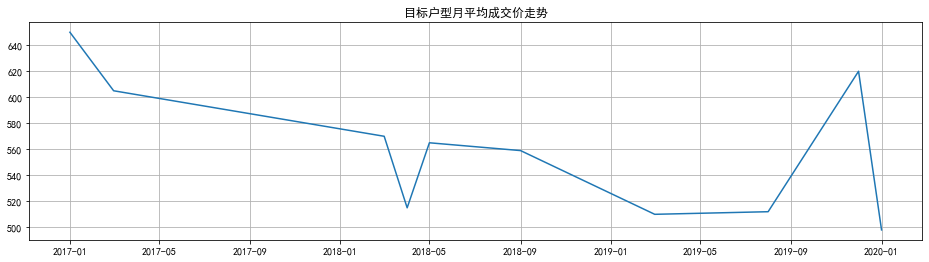

In [70]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate[candidate['is_lianjia_deal']==True].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型月平均成交价走势')
plt.show()

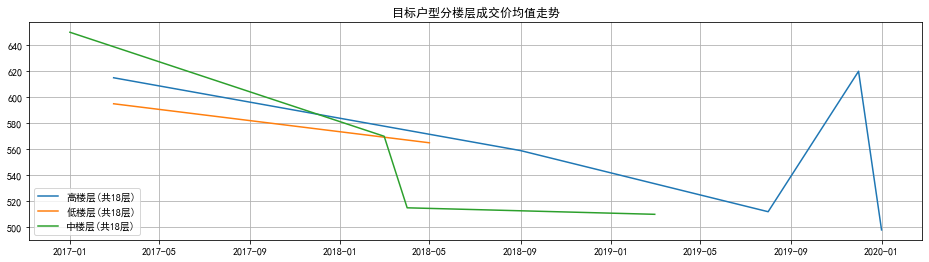

In [71]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('目标户型分楼层成交价均值走势')
plt.show()

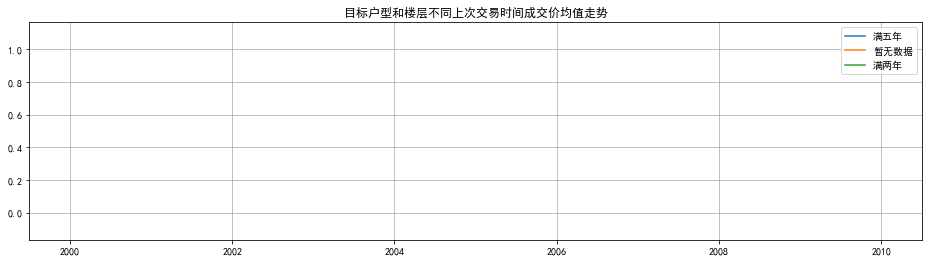

In [72]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['last_transaction_duration'].unique():
    plt.plot(candidate[(candidate['last_transaction_duration']==t) & (candidate['floor']=='底层(共6层)') ].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(candidate['last_transaction_duration'].unique(),loc='best')
plt.title('目标户型和楼层不同上次交易时间成交价均值走势')
plt.show()

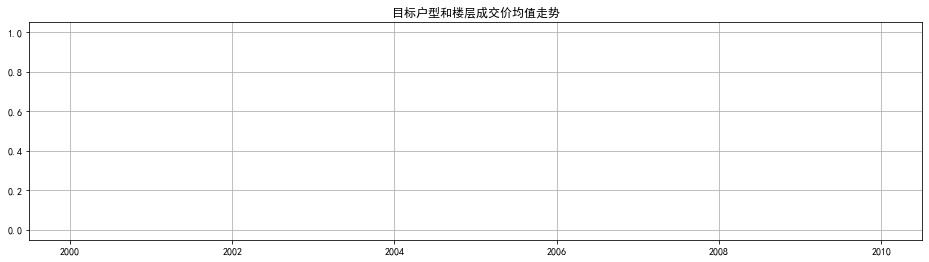

In [59]:
fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
plt.plot(candidate[(candidate['floor']=='底层(共6层)') & (candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_price'])
#plt.plot(candidate.groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.title('目标户型和楼层成交价均值走势')
plt.show()

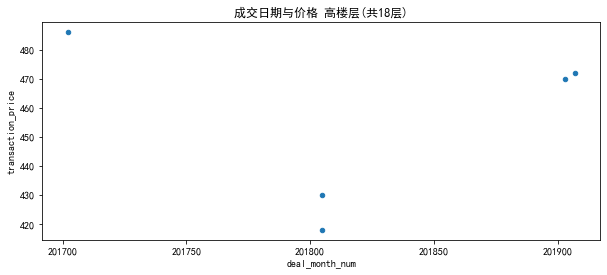

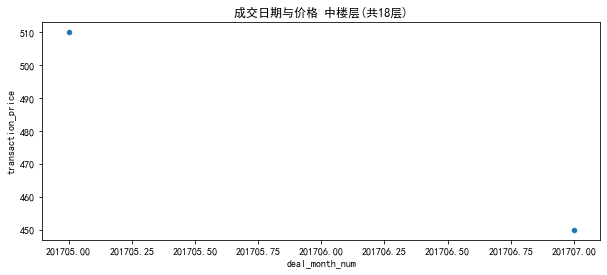

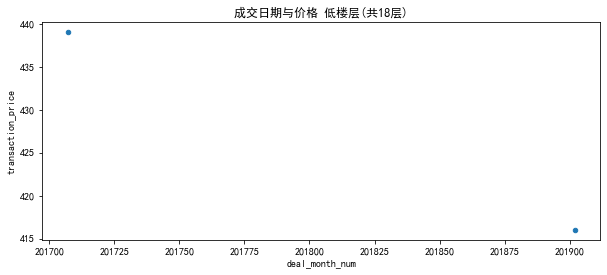

In [60]:
for t in candidate['floor'].unique():
    ax=candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)][['transaction_price','deal_month_num']].plot(kind='scatter',x='deal_month_num', y='transaction_price',figsize=(10,4),title='成交日期与价格 '+t)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

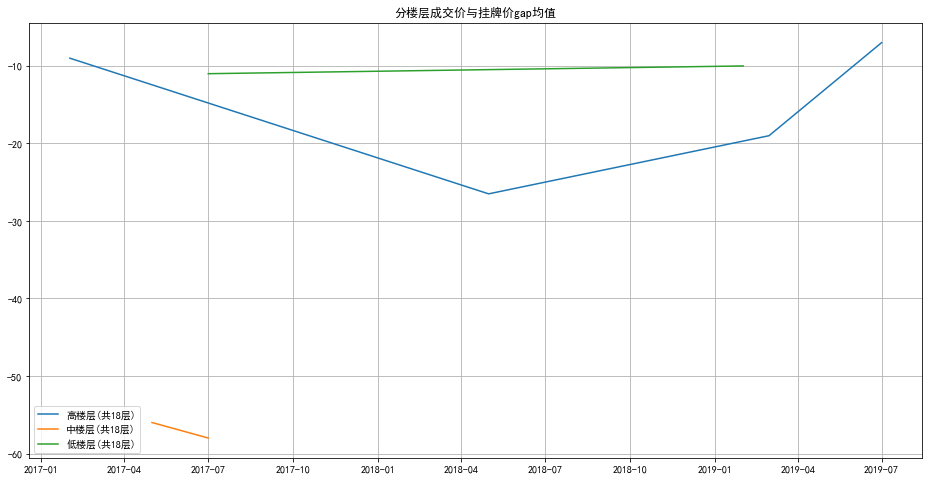

In [61]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in candidate['floor'].unique():
    plt.plot(candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(candidate['floor'].unique(),loc='best')
plt.title('分楼层成交价与挂牌价gap均值')
plt.show()

价格gap线框图分布

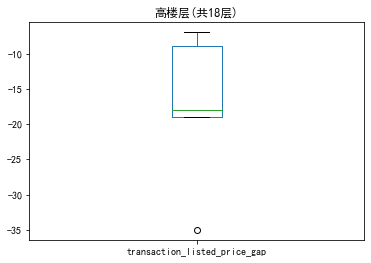

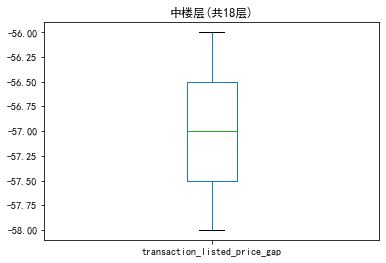

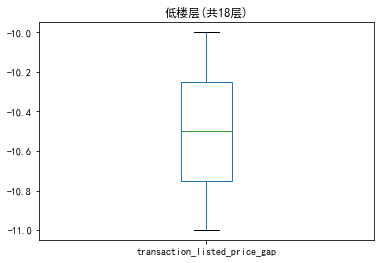

In [62]:
for t in candidate['floor'].unique():
    candidate[(candidate['floor']==t)&(candidate['is_lianjia_deal']==True)][['transaction_listed_price_gap']].plot(kind='box', title=t)


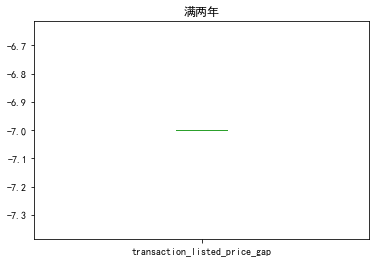

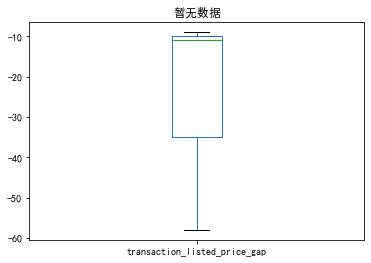

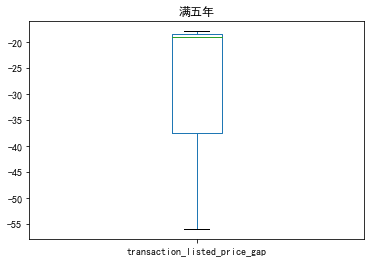

In [63]:
for t in candidate['last_transaction_duration'].unique():
    candidate[(candidate['last_transaction_duration']==t)&(candidate['is_lianjia_deal']==True)][['transaction_listed_price_gap']].plot(kind='box', title=t)